In [4]:
! pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 34.2 MB/s eta 0:00:00


In [5]:
# load package
import shap
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
import ssl
# load build-in dataset
ssl._create_default_https_context = ssl._create_unverified_context
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
# reshape and normalize data
x_train = x_train.reshape(50000, 32, 32, 3).astype("float32") / 255
x_test = x_test.reshape(10000, 32, 32, 3).astype("float32") / 255
y_train = y_train.reshape(50000,)
y_test = y_test.reshape(10000,)

170498071/170498071 [==============================] - 14s 0us/step


In [6]:
# define the model architecture
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Conv2D(128, (3, 3), activation='relu')(inputs)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)
outputs = keras.layers.Dense(10, activation='softmax')(x)
# inputs and outputs
model = keras.Model(inputs=inputs, outputs=outputs, name="test_for_shap")
# compile the model
model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=keras.optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 10)

Epoch 1/10
1563/1563 [==============================] - 18s 5ms/step - loss: 1.4280 - sparse_categorical_accuracy: 0.4879 - val_loss: 1.1824 - val_sparse_categorical_accuracy: 0.5841
Epoch 2/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.0876 - sparse_categorical_accuracy: 0.6158 - val_loss: 1.0715 - val_sparse_categorical_accuracy: 0.6252
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9261 - sparse_categorical_accuracy: 0.6750 - val_loss: 1.0515 - val_sparse_categorical_accuracy: 0.6347
Epoch 4/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.8060 - sparse_categorical_accuracy: 0.7168 - val_loss: 1.0415 - val_sparse_categorical_accuracy: 0.6461
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7021 - sparse_categorical_accuracy: 0.7533 - val_loss: 1.0123 - val_sparse_categorical_accuracy: 0.6559
Epoch 6/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.6002 - spar

In [7]:
model.summary()

Model: "test_for_shap"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 256)               1843456   
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                     

In [8]:
# class label list
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
# example image for each class
images_dict = dict()
for i, l in enumerate(y_train):
  if len(images_dict)==10:
    break
  if l not in images_dict.keys():
    images_dict[l] = x_train[i].reshape((32, 32,3))
images_dict = dict(sorted(images_dict.items()))
    
# example image for each class for test set
x_test_dict = dict()
for i, l in enumerate(y_test):
  if len(x_test_dict)==10:
    break
  if l not in x_test_dict.keys():
    x_test_dict[l] = x_test[i]
# order by class
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]
x_test_each_class = np.asarray(x_test_each_class)
# Compute predictions
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 114ms/step


In [10]:
# plot actual and predicted class
def plot_actual_predicted(images, pred_classes):
  fig, axes = plt.subplots(1, 11, figsize=(16, 15))
  axes = axes.flatten()
  
  # plot
  ax = axes[0]
  dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
  ax.set_title("Base reference")
  ax.set_axis_off()
  ax.imshow(dummy_array, interpolation='nearest')
  # plot image
  for k,v in images.items():
    ax = axes[k+1]
    ax.imshow(v, cmap=plt.cm.binary)
    ax.set_title(f"True: %s \nPredict: %s" % (class_names[k], class_names[pred_classes[k]]))
    ax.set_axis_off()
  plt.tight_layout()
  plt.show()

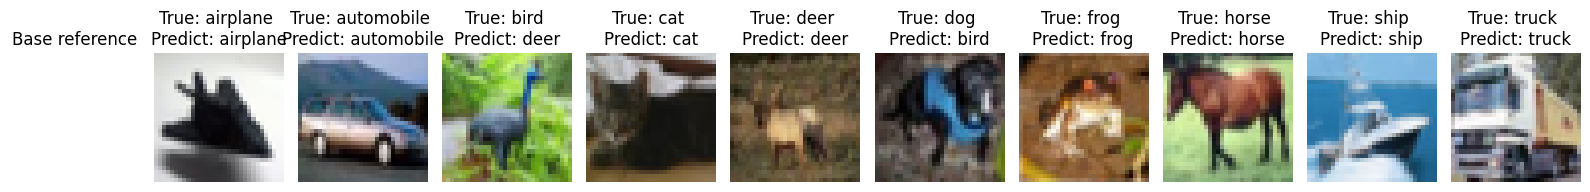

In [11]:
plot_actual_predicted(images_dict,predicted_class)

In [12]:
# select backgroud for shap
background = x_train[np.random.choice(x_train.shape[0], 1000, replace=False)]
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(model, background)
# compute shap values
shap_values = explainer.shap_values(x_test_each_class)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


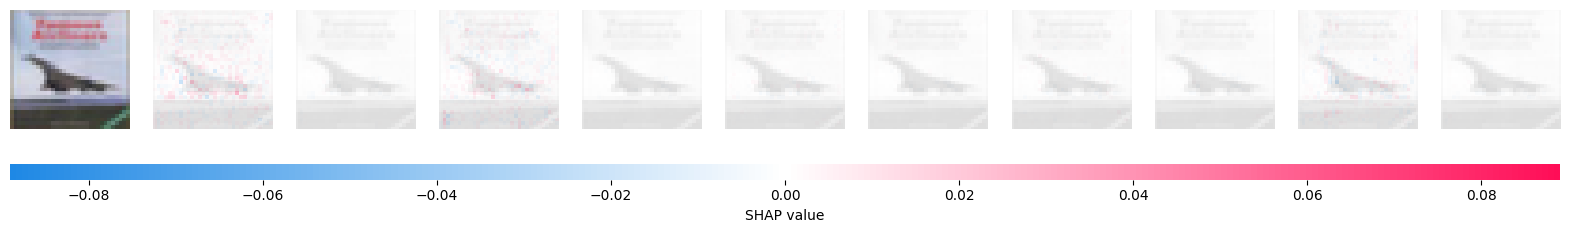

In [15]:
shap.image_plot(shap_values,x_test_each_class[:1])